# Stratégie entrainement fine tuning BERT

## Objectifs de ce notebook

L'objectif est d'obtenir un modèle bert finetuné avec des performances qui s'améliore progressivement en fil des expérimentations.

Travaux sur les reviews et les preset **bert english**

Le plan d'entrainement découpé en plusieurs phases:

- phase 1: entrainer un grand nombre de modèles bert small sur un dataset réduit en testant plusieurs combinaisons d'hyper-paramétres.
- phase 2: prendre les 6 meilleures combinaisons d'hyperparamétre et entrainer un modèle small sur le dataset complet
- phase 3: prendre la meilleure combinaison et entrainer les modèles de base
bert_base_en et distill_bert_base

## Import des librairies

In [146]:
from datetime import datetime

import numpy as np
import pandas as pd
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

from IPython.display import display, Markdown

import keras_nlp
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [147]:
# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## Méthodes utiles

In [148]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()

        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(
                f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)"
            )

        summary.append(
            {
                "Column": col,
                "Type": str(col_type),
                "Non-Null Count": non_null,
                "Null Count": null_count,
                "Unique Values": unique_count,
            }
        )

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [149]:
def show_combinaisons_stats(combinations,learning_rate_list,layer_architecture_list,callback_s_list,subset_size,finetune_model_config):
    df_combinations = pd.DataFrame(
    combinations, 
    columns=["Model", "Learning Rate", "Architecture", "Callback Strategy"]
    )

    df_combinations.index = [f"Run {i+1}" for i in range(len(df_combinations))]

    print(f"Total de combinaisons : {len(df_combinations)}\n")
    print("="*80)

    # Afficher le DataFrame complet
    print(df_combinations)
    print("="*80)

    # Afficher un résumé des hyperparamètres
    print(f"\nRésumé des hyperparamètres :")
    print(f"   • Modèles : {df_combinations['Model'].nunique()} ({df_combinations['Model'].unique()[0]})")
    print(f"   • Learning rates : {df_combinations['Learning Rate'].nunique()} {learning_rate_list}")
    print(f"   • Architectures : {df_combinations['Architecture'].nunique()} {layer_architecture_list}")
    print(f"   • Callback strategies : {df_combinations['Callback Strategy'].nunique()} {callback_s_list}")
    print(f"   • Dataset size : {subset_size:,} reviews")
    print(f"   • Batch size : {finetune_model_config['BATCH_SIZE']}")
    print(f"   • Max epochs : {finetune_model_config['EPOCHS']}")
    print(f"   • Sequence length : {finetune_model_config['SEQUENCE_LENGTH']}")

In [150]:
def show_stats_compare_train_evaluation(df:pd.DataFrame,best_count = 6):
    df['duration_seconds'] = pd.to_timedelta(df['duration']).dt.total_seconds()

    print("Analyse des Résultats")

    print(f"Nombre de runs : {len(df)}")
    print(f"Dataset : {df['reviews_subset'].iloc[0]:,} reviews")
    print()

    # Top Configurations
    print(f"Top {best_count} Meilleures Configurations")
    print("="*80)

    top6 = df.nlargest(best_count, 'test_accuracy')[['learning_rate', 'layer_architecture', 
                                            'callback_strategy', 'test_accuracy', 
                                            'test_loss', 'macro_avg_f1_score', 
                                            'weighted_avg_f1_score', 'duration']].copy()
    top6.index = range(1, best_count+1)
    top6.columns = ['LR', 'Arch', 'CB', 'Accuracy', 'Loss', 'Macro F1', 'Weighted F1', 'Duration']

    print(top6.to_string())
    print()

    # Statistiques Globales
    print("Statistiques Globales")
    print("="*80)

    stats_df = pd.DataFrame({
        'Métrique': ['Accuracy', 'F1-Score (Macro)', 'Loss'],
        'Meilleur': [
            f"{df['test_accuracy'].max():.4f}",
            f"{df['macro_avg_f1_score'].max():.4f}",
            f"{df['test_loss'].min():.4f}"
        ],
        'Pire': [
            f"{df['test_accuracy'].min():.4f}",
            f"{df['macro_avg_f1_score'].min():.4f}",
            f"{df['test_loss'].max():.4f}"
        ],
        'Moyenne': [
            f"{df['test_accuracy'].mean():.4f}",
            f"{df['macro_avg_f1_score'].mean():.4f}",
            f"{df['test_loss'].mean():.4f}"
        ],
        'Écart-type': [
            f"{df['test_accuracy'].std():.4f}",
            f"{df['macro_avg_f1_score'].std():.4f}",
            f"{df['test_loss'].std():.4f}"
        ]
    })

    print(stats_df.to_string(index=False))
    print()

    # Recommandations
    best_run = df.loc[df['test_accuracy'].idxmax()]

    recommendations = pd.DataFrame({
        'Hyperparamètre': ['Learning Rate', 'Architecture', 'Callback Strategy', 'Accuracy Obtenue'],
        'Valeur Optimale': [
            f"{best_run['learning_rate']}",
            f"{int(best_run['layer_architecture'])}",
            f"{int(best_run['callback_strategy'])}",
            f"{best_run['test_accuracy']:.4f} ({best_run['test_accuracy']*100:.2f}%)"
        ]
    })

    print(recommendations.to_string(index=False))
    print()

In [151]:
def show_plt_distribution_accuracy_result(df:pd.DataFrame):
    # Créer un label pour chaque configuration
    df['config'] = df.apply(lambda x: f"LR:{x['learning_rate']:.0e}\nArch:{int(x['layer_architecture'])}\nCB:{int(x['callback_strategy'])}", axis=1)

    # Graphique
    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(df)), df['test_accuracy'], color='steelblue', edgecolor='black')

    plt.xlabel('Configuration')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy - Toutes les Configurations')
    plt.xticks(range(len(df)), range(1, len(df)+1), rotation=0)

    # ZOOM sur l'axe Y
    min_acc = df['test_accuracy'].min()
    max_acc = df['test_accuracy'].max()
    margin = (max_acc - min_acc) * 0.1  # 10% de marge
    plt.ylim(min_acc - margin, max_acc + margin)


    plt.axhline(df['test_accuracy'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df["test_accuracy"].mean():.4f}')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.savefig('../outputs/all_models_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

## Phase 1 expérimenter différente combinaisons d'hyper-paramétres

### Test de différentes architecture de couches de sorties

In [152]:
# Rappel du contexte
# if use_sequence_output:  # BERT
#     bert_output = bert_backbone(inputs)["sequence_output"]
# else:  # DistillBERT
#     bert_output = bert_backbone(inputs)

# Extraction du token [CLS] (premier token)
# cls_token = bert_output[:, 0, :]

# # 0 - Architecture la plus simple
# 
# x = layers.Dropout(0.1)(cls_token)

# # 1 - Architecture vu pendant la formation
# 
# x = layers.Dropout(0.3)(cls_token)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.Dropout(0.3)(x)

# # 2 - Architecture plus équilibré
# 
# x = layers.Dropout(0.2)(cls_token)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.2)(x)

# # 3 - Architecture plus complexe
# 
# x = layers.Dropout(0.3)(cls_token)
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.Dropout(0.3)(x)

# # Dernière couche commune pour la classification binaire
# 
# output = layers.Dense(1, activation="sigmoid", name="classifier")(x)
# model = keras.Model(inputs, output)

### Tests de différents stratégie de callback

In [153]:

# 0 - Pour tests rapides agressif
callback_es = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
)
callback_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=1, min_lr=1e-7, verbose=1
)

# 1 - Pour fine-tuning BERT (équilibré)
callback_es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1,
)
callback_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-7,
    cooldown=1,
    min_delta=0.001,
    verbose=1,
)

# 2 - Pour fine-tuning BERT (équilibré un petit peu plus patient)
callback_es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1,
)
callback_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-7,
    cooldown=1,
    min_delta=0.001,
    verbose=1,
)

# 3 - Pour entraînement long (patient)
callback_es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    min_delta=0.0005,
    verbose=1,
)
callback_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-8,
    cooldown=2,
    verbose=1,
)

### Phase 1 - Liste des modèles à tester

- 3 Types de learning rate de départ
- 3 Types d'architecture de couches de sorties
- 3 Types de stratégies de callback

Subset réduits mais quand même représentatif (50 000 reviews)

In [154]:
# quick_test_presets = [
#     "bert_small_en_uncased",
# ]
# Test all combo LR + layer architectures + callback patience

learning_rate_list = [2e-5, 3e-5, 5e-5]
layer_architecture_list = [0, 1, 2]
subset_size = 50000
callback_s_list = [0, 1, 2]  # 0 - 1 - 2 (plus rapide au plus patient)

finetune_model_config = {
    "NAME_TRAIN_CONFIG": "Hyperparameter Search phase 1",
    "PHASE_NAME": "en_phase1",
    "SEED": 42,
    "REVIEWS_DATA_FILE": "reviews_en_processed.csv",
    "REVIEWS_SUBSET": subset_size,
    "BATCH_SIZE": 32,
    "EPOCHS": 10,  # pour être sur car early stopping
    "SEQUENCE_LENGTH": 128,
    "USE_TF_DATASET": False,  # opti batch memory
    "PLT_COLOR": "green",
}

combinations = []

# BERT small fast finetuning - (27 combo)
for arch in layer_architecture_list:
    for lr in learning_rate_list:
        for cs in callback_s_list:
            combinations.append(("bert_small_en_uncased", lr, arch, cs))

df_combinations = pd.DataFrame(
    combinations, 
    columns=["Model", "Learning Rate", "Architecture", "Callback Strategy"]
)

df_combinations.index = [f"Run {i+1}" for i in range(len(df_combinations))]

print(f"Total de combinaisons : {len(df_combinations)}\n")
print("="*80)

# Afficher le DataFrame complet
print(df_combinations)
print("="*80)

# Afficher un résumé des hyperparamètres
print(f"\nRésumé des hyperparamètres :")
print(f"   • Modèles : {df_combinations['Model'].nunique()} ({df_combinations['Model'].unique()[0]})")
print(f"   • Learning rates : {df_combinations['Learning Rate'].nunique()} {learning_rate_list}")
print(f"   • Architectures : {df_combinations['Architecture'].nunique()} {layer_architecture_list}")
print(f"   • Callback strategies : {df_combinations['Callback Strategy'].nunique()} {callback_s_list}")
print(f"   • Dataset size : {subset_size:,} reviews")
print(f"   • Batch size : {finetune_model_config['BATCH_SIZE']}")
print(f"   • Max epochs : {finetune_model_config['EPOCHS']}")
print(f"   • Sequence length : {finetune_model_config['SEQUENCE_LENGTH']}")

Total de combinaisons : 27

                        Model  Learning Rate  Architecture  Callback Strategy
Run 1   bert_small_en_uncased        0.00002             0                  0
Run 2   bert_small_en_uncased        0.00002             0                  1
Run 3   bert_small_en_uncased        0.00002             0                  2
Run 4   bert_small_en_uncased        0.00003             0                  0
Run 5   bert_small_en_uncased        0.00003             0                  1
Run 6   bert_small_en_uncased        0.00003             0                  2
Run 7   bert_small_en_uncased        0.00005             0                  0
Run 8   bert_small_en_uncased        0.00005             0                  1
Run 9   bert_small_en_uncased        0.00005             0                  2
Run 10  bert_small_en_uncased        0.00002             1                  0
Run 11  bert_small_en_uncased        0.00002             1                  1
Run 12  bert_small_en_uncased       

### Script python d'entrainement séquentiel phase 1

`python -m src.scripts.fine_tuning.run_phase1_fast_fine_tuning_to_find_best_hyperparams`

/outputs/evaluation_results_en_phase1.csv

### Affichage des résultats

In [155]:
df = pd.read_csv('../outputs/evaluation_results_en_phase1.csv')
show_stats_compare_train_evaluation(df)
   

Analyse des Résultats
Nombre de runs : 20
Dataset : 50,000 reviews

Top 6 Meilleures Configurations
        LR  Arch  CB  Accuracy      Loss  Macro F1  Weighted F1 Duration
1  0.00005     1   1    0.8826  0.310499  0.882599     0.882599  0:03:39
2  0.00005     1   2    0.8816  0.308429  0.881595     0.881595  0:04:16
3  0.00003     1   2    0.8802  0.313572  0.880196     0.880197  0:04:15
4  0.00003     1   0    0.8800  0.311184  0.879979     0.879980  0:02:55
5  0.00003     0   1    0.8786  0.321366  0.878546     0.878548  0:03:35
6  0.00003     0   0    0.8784  0.321401  0.878345     0.878347  0:02:55

Statistiques Globales
        Métrique Meilleur   Pire Moyenne Écart-type
        Accuracy   0.8826 0.8726  0.8776     0.0023
F1-Score (Macro)   0.8826 0.8725  0.8775     0.0023
            Loss   0.3084 0.3271  0.3169     0.0055

   Hyperparamètre Valeur Optimale
    Learning Rate           5e-05
     Architecture               1
Callback Strategy               1
 Accuracy Obtenue 0.8

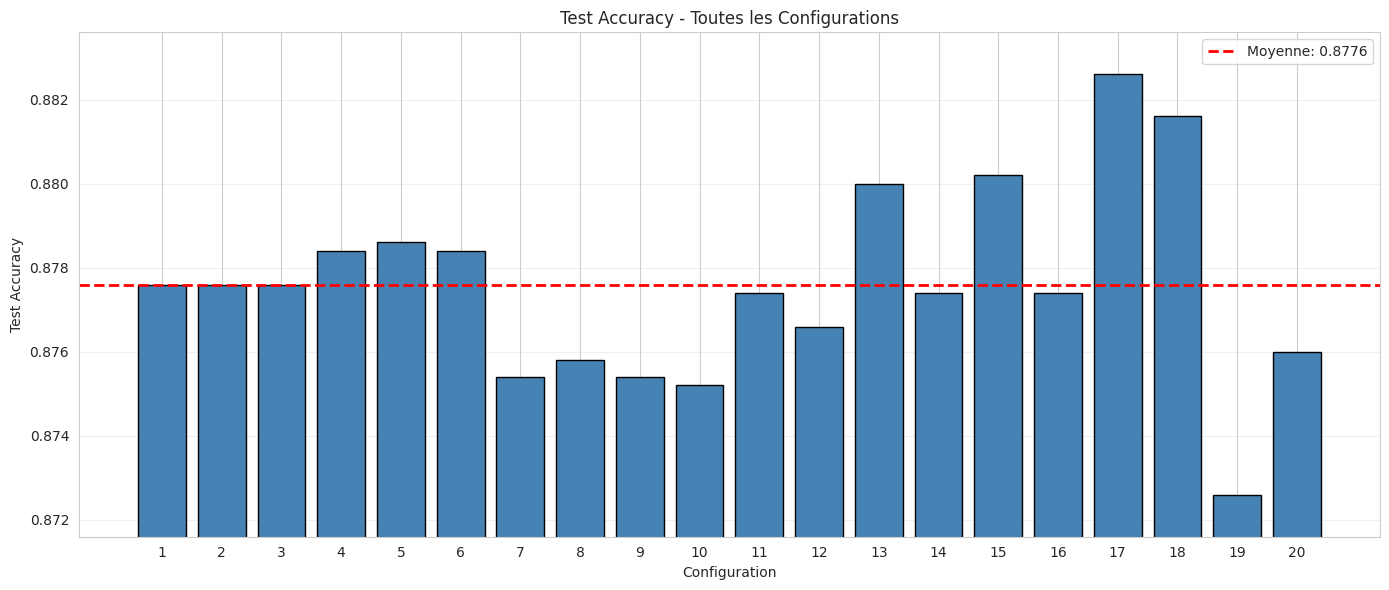

In [156]:
show_plt_distribution_accuracy_result(df)

## Phase 2 valider hyper-paramétres sur le dataset anglais complet

### Phase 2 - Liste des modèles à tester

- Analyse des résultats phase 1 

In [157]:
# Tester toutes les combinaisons LR + architectures
learning_rate_list = [2e-5, 3e-5, 5e-5]
layer_architecture_list = [0, 1]
subset_size = -1  # Toute les reviews
callback_s = 1  # 0 - 1 - 2 (plus rapide au plus patient)

combinations = []

# BERT VALIDATION HYPER PARAMETRES - (6 combo)
for arch in layer_architecture_list:
    for lr in learning_rate_list:
        combinations.append(("bert_small_en_uncased", lr, arch, callback_s))
        
show_combinaisons_stats(combinations,learning_rate_list,layer_architecture_list,callback_s,subset_size,finetune_model_config)

Total de combinaisons : 6

                       Model  Learning Rate  Architecture  Callback Strategy
Run 1  bert_small_en_uncased        0.00002             0                  1
Run 2  bert_small_en_uncased        0.00003             0                  1
Run 3  bert_small_en_uncased        0.00005             0                  1
Run 4  bert_small_en_uncased        0.00002             1                  1
Run 5  bert_small_en_uncased        0.00003             1                  1
Run 6  bert_small_en_uncased        0.00005             1                  1

Résumé des hyperparamètres :
   • Modèles : 1 (bert_small_en_uncased)
   • Learning rates : 3 [2e-05, 3e-05, 5e-05]
   • Architectures : 2 [0, 1]
   • Callback strategies : 1 1
   • Dataset size : -1 reviews
   • Batch size : 32
   • Max epochs : 10
   • Sequence length : 128


### Script python d'entrainement séquentiel phase 2

`python -m src.scripts.fine_tuning.run_phase2_small_fine_tuning`

/outputs/evaluation_results_en_phase2.csv

### Affichage résultat phase 2

In [158]:
df = pd.read_csv('../outputs/evaluation_results_en_phase2.csv')
show_stats_compare_train_evaluation(df)


Analyse des Résultats
Nombre de runs : 6
Dataset : 229,102 reviews

Top 6 Meilleures Configurations
        LR  Arch  CB  Accuracy      Loss  Macro F1  Weighted F1 Duration
1  0.00003     1   1  0.902056  0.256064  0.901985     0.901985  0:15:11
2  0.00005     1   1  0.901794  0.257181  0.901674     0.901674  0:15:15
3  0.00005     0   1  0.900659  0.249249  0.900624     0.900624  0:11:45
4  0.00003     0   1  0.899524  0.255007  0.899493     0.899494  0:11:58
5  0.00002     1   1  0.899175  0.263931  0.899096     0.899096  0:15:08
6  0.00002     0   1  0.897647  0.259041  0.897589     0.897589  0:12:07

Statistiques Globales
        Métrique Meilleur   Pire Moyenne Écart-type
        Accuracy   0.9021 0.8976  0.9001     0.0017
F1-Score (Macro)   0.9020 0.8976  0.9001     0.0017
            Loss   0.2492 0.2639  0.2567     0.0048

   Hyperparamètre Valeur Optimale
    Learning Rate           3e-05
     Architecture               1
Callback Strategy               1
 Accuracy Obtenue 0.9

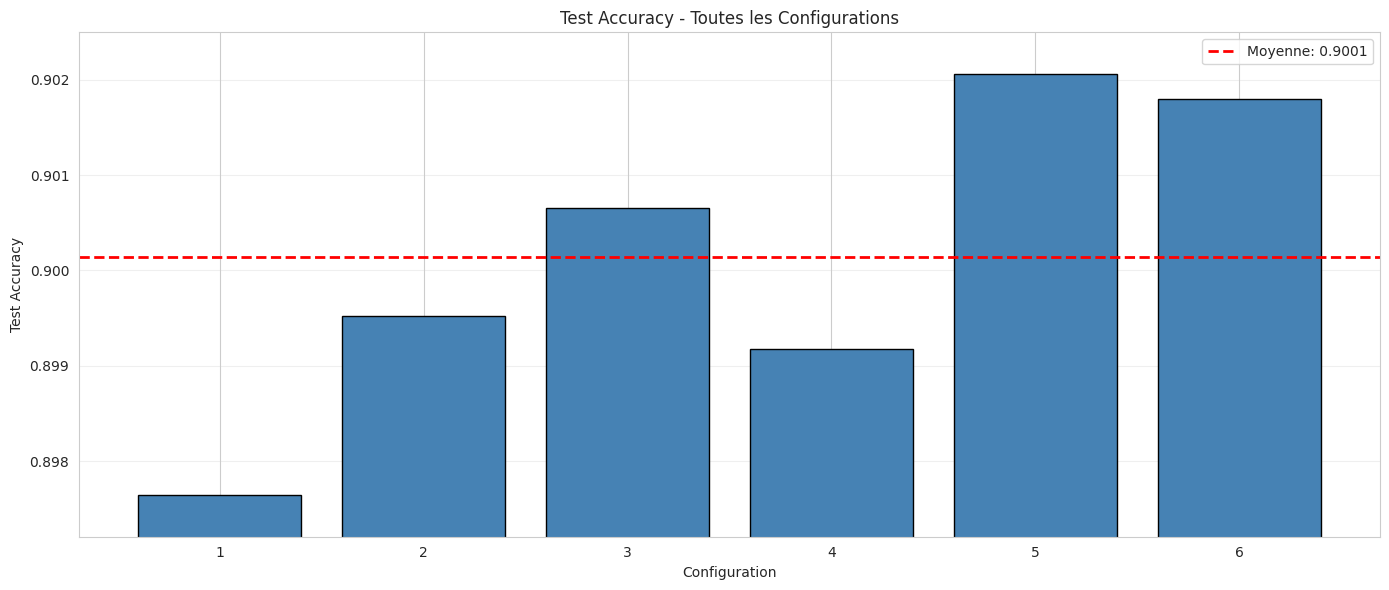

In [159]:
show_plt_distribution_accuracy_result(df)

## Phase 3 Entrainement modèle bert base

### Phase 3 - Liste des modèles à tester
- bert_base_en_uncased
- distil_bert_base_en_uncased

Hyper-paramétres équilibrés après analyse des résultats phase 1 et 2

In [160]:
# Tester toutes les combinaisons LR + architectures
learning_rate_list = [3e-5]
layer_architecture_list = [1]
subset_size = -1  # Toute les reviews
callback_s = [2]  # 0 - 1 - 2 - 3 (plus rapide au plus patient)

combinations = []

combinations.append(
    (
        "bert_base_en_uncased",
        learning_rate_list[0],
        layer_architecture_list[0],
        callback_s[0],
    )
)

combinations.append(
    (
        "distil_bert_base_en_uncased",
        learning_rate_list[0],
        layer_architecture_list[0],
        callback_s[0],
    )
)

show_combinaisons_stats(combinations,learning_rate_list,layer_architecture_list,callback_s,subset_size,finetune_model_config)

Total de combinaisons : 2

                             Model  Learning Rate  Architecture  \
Run 1         bert_base_en_uncased        0.00003             1   
Run 2  distil_bert_base_en_uncased        0.00003             1   

       Callback Strategy  
Run 1                  2  
Run 2                  2  

Résumé des hyperparamètres :
   • Modèles : 2 (bert_base_en_uncased)
   • Learning rates : 1 [3e-05]
   • Architectures : 1 [1]
   • Callback strategies : 1 [2]
   • Dataset size : -1 reviews
   • Batch size : 32
   • Max epochs : 10
   • Sequence length : 128


In [161]:
df = pd.read_csv('../outputs/evaluation_results_en_phase3.csv')
show_stats_compare_train_evaluation(df,best_count=2)

Analyse des Résultats
Nombre de runs : 2
Dataset : 229,102 reviews

Top 2 Meilleures Configurations
        LR  Arch  CB  Accuracy      Loss  Macro F1  Weighted F1 Duration
1  0.00003     1   2  0.919035  0.210698  0.918972     0.918972  1:16:55
2  0.00003     1   2  0.912226  0.229292  0.912192     0.912192  0:39:51

Statistiques Globales
        Métrique Meilleur   Pire Moyenne Écart-type
        Accuracy   0.9190 0.9122  0.9156     0.0048
F1-Score (Macro)   0.9190 0.9122  0.9156     0.0048
            Loss   0.2107 0.2293  0.2200     0.0131

   Hyperparamètre Valeur Optimale
    Learning Rate           3e-05
     Architecture               1
Callback Strategy               2
 Accuracy Obtenue 0.9190 (91.90%)



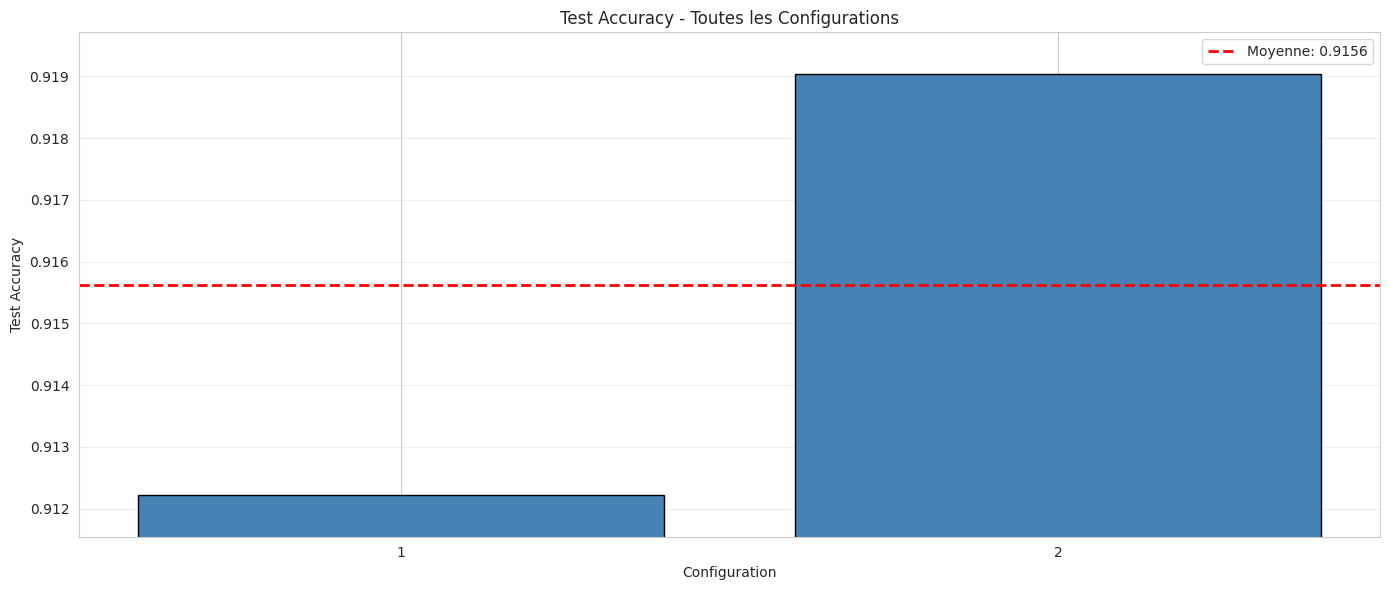

In [163]:
show_plt_distribution_accuracy_result(df)

Le modèle distill bert reste intéressant pour la production

## Conclusion

Evolution performance du modèle au fur et à mesure des expérimentations:

Evolution de l'Accuracy

- **baseline :** 0.82 (20 000 - small)
- **phase 1:**   0.88 (50 000 - small)
- **phase 2:**   0.90 (220 000 - small)
- **phase 3:**   0.92 (220 000 - base)

- **phase 4:** entrainer des modèles plus large comme roberta, deberta_v3
- **phase 5:** entrainer des modèles en dehors de keras 3 comme bertweet 